In [45]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [46]:
# # Transformação: converte para tensor e normaliza (média e desvio de MNIST)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Dataset de treino e teste
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Subset com os primeiros 1000 para treino e 500 para validação
# train_subset = Subset(train_dataset, range(1000))
# val_subset   = Subset(test_dataset, range(500))

# # DataLoaders
# train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
# val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

In [47]:
# Transformação padrão para Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Dataset Fashion-MNIST
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Subsets reduzidos
train_subset = Subset(full_train_dataset, range(200))
val_subset   = Subset(full_val_dataset, range(200))

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

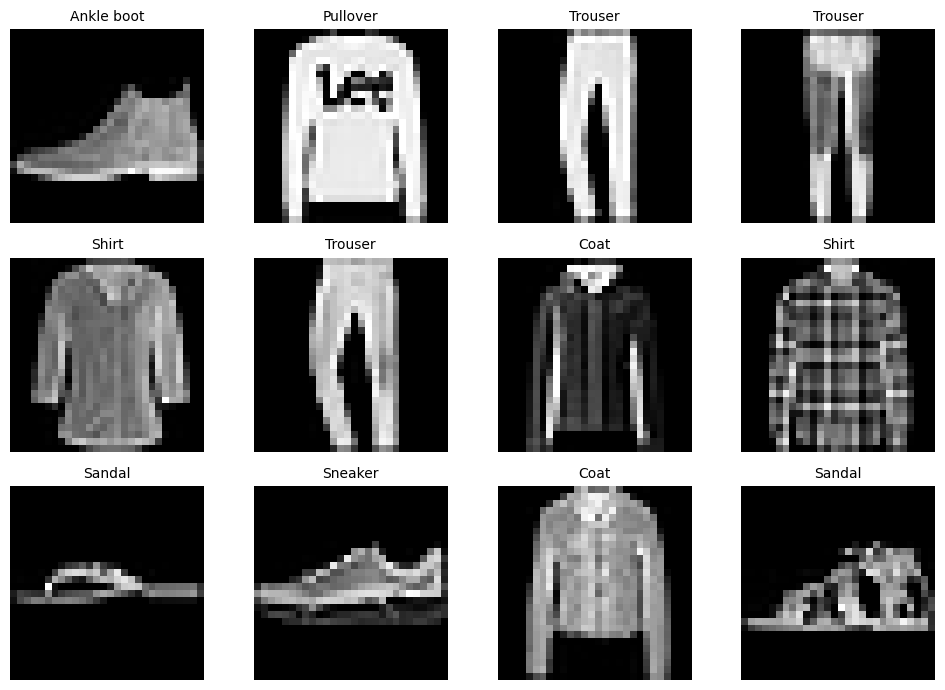

In [48]:
# Classe names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Mostrar 12 imagens
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    img, label = val_subset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(class_names[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [49]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_training_history(history):
    epochs = range(1, len(history['train_losses']) + 1)

    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracies
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [50]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

100%|██████████| 4/4 [00:00<00:00, 58.14it/s]


Epoch 1, Train Loss: 2.307, Train Accuracy: 19.00%
Epoch 1, Val Loss: 2.292, Val Accuracy: 20.50%


100%|██████████| 4/4 [00:00<00:00, 59.64it/s]


Epoch 2, Train Loss: 2.301, Train Accuracy: 19.50%
Epoch 2, Val Loss: 2.273, Val Accuracy: 15.50%


100%|██████████| 4/4 [00:00<00:00, 62.35it/s]


Epoch 3, Train Loss: 2.279, Train Accuracy: 15.00%
Epoch 3, Val Loss: 2.253, Val Accuracy: 13.50%


100%|██████████| 4/4 [00:00<00:00, 66.46it/s]


Epoch 4, Train Loss: 2.245, Train Accuracy: 13.00%
Epoch 4, Val Loss: 2.224, Val Accuracy: 14.50%


100%|██████████| 4/4 [00:00<00:00, 53.74it/s]


Epoch 5, Train Loss: 2.222, Train Accuracy: 13.00%
Epoch 5, Val Loss: 2.177, Val Accuracy: 13.50%


100%|██████████| 4/4 [00:00<00:00, 66.63it/s]


Epoch 6, Train Loss: 2.190, Train Accuracy: 13.00%
Epoch 6, Val Loss: 2.108, Val Accuracy: 13.50%


100%|██████████| 4/4 [00:00<00:00, 65.52it/s]


Epoch 7, Train Loss: 2.065, Train Accuracy: 13.50%
Epoch 7, Val Loss: 2.010, Val Accuracy: 18.50%


100%|██████████| 4/4 [00:00<00:00, 66.42it/s]


Epoch 8, Train Loss: 1.970, Train Accuracy: 25.50%
Epoch 8, Val Loss: 1.862, Val Accuracy: 38.50%


100%|██████████| 4/4 [00:00<00:00, 67.76it/s]


Epoch 9, Train Loss: 1.812, Train Accuracy: 44.00%
Epoch 9, Val Loss: 1.657, Val Accuracy: 52.00%


100%|██████████| 4/4 [00:00<00:00, 67.04it/s]


Epoch 10, Train Loss: 1.460, Train Accuracy: 62.00%
Epoch 10, Val Loss: 1.372, Val Accuracy: 55.50%


100%|██████████| 4/4 [00:00<00:00, 63.56it/s]


Epoch 11, Train Loss: 1.156, Train Accuracy: 57.00%
Epoch 11, Val Loss: 1.406, Val Accuracy: 49.50%


100%|██████████| 4/4 [00:00<00:00, 68.55it/s]


Epoch 12, Train Loss: 1.072, Train Accuracy: 50.00%
Epoch 12, Val Loss: 1.431, Val Accuracy: 57.00%


100%|██████████| 4/4 [00:00<00:00, 66.97it/s]


Epoch 13, Train Loss: 0.903, Train Accuracy: 62.00%
Epoch 13, Val Loss: 1.506, Val Accuracy: 54.50%


100%|██████████| 4/4 [00:00<00:00, 64.34it/s]


Epoch 14, Train Loss: 1.144, Train Accuracy: 55.50%
Epoch 14, Val Loss: 1.355, Val Accuracy: 59.00%


100%|██████████| 4/4 [00:00<00:00, 65.16it/s]


Epoch 15, Train Loss: 1.003, Train Accuracy: 63.00%
Epoch 15, Val Loss: 1.194, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 68.42it/s]


Epoch 16, Train Loss: 0.904, Train Accuracy: 65.00%
Epoch 16, Val Loss: 1.191, Val Accuracy: 52.00%


100%|██████████| 4/4 [00:00<00:00, 67.86it/s]


Epoch 17, Train Loss: 1.009, Train Accuracy: 64.50%
Epoch 17, Val Loss: 1.102, Val Accuracy: 61.50%


100%|██████████| 4/4 [00:00<00:00, 63.34it/s]


Epoch 18, Train Loss: 0.836, Train Accuracy: 70.00%
Epoch 18, Val Loss: 0.965, Val Accuracy: 63.50%


100%|██████████| 4/4 [00:00<00:00, 68.09it/s]


Epoch 19, Train Loss: 0.794, Train Accuracy: 73.00%
Epoch 19, Val Loss: 0.827, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 64.54it/s]


Epoch 20, Train Loss: 0.651, Train Accuracy: 79.50%
Epoch 20, Val Loss: 0.895, Val Accuracy: 65.50%
Treinamento concluído


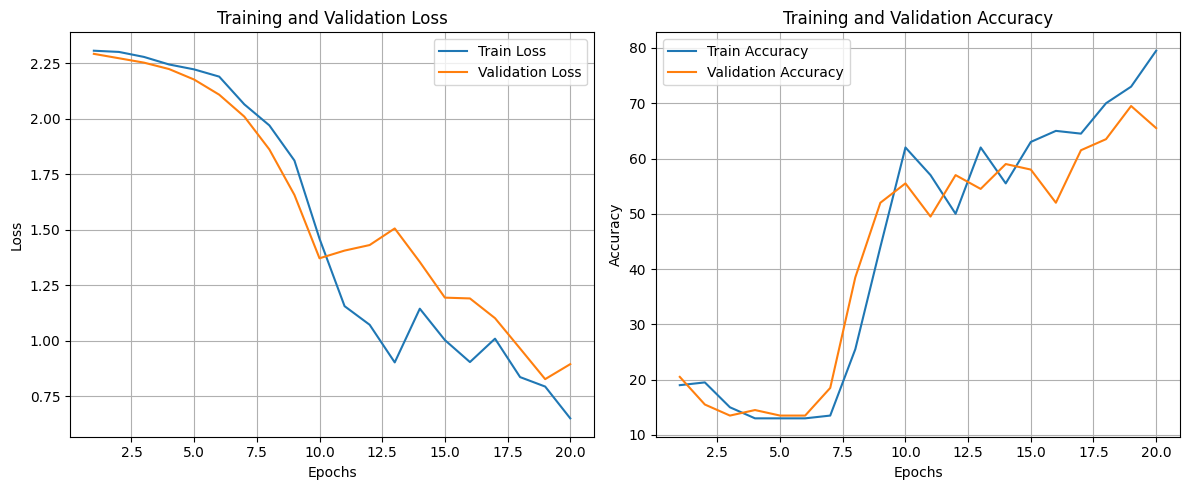

Acurácia da rede na base de teste: 65.50%


In [51]:
model_1 = CNN(
    initialize_weights=False,
    dropout=0.0
)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_1 = train_model(
    model=model_1,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_1,
    optimizer=optimizer_1,
    num_epochs=20
)

plot_training_history(history_1)

test_model(model_1, val_loader)

100%|██████████| 4/4 [00:00<00:00, 61.67it/s]


Epoch 1, Train Loss: 2.382, Train Accuracy: 10.50%
Epoch 1, Val Loss: 2.210, Val Accuracy: 14.50%


100%|██████████| 4/4 [00:00<00:00, 67.95it/s]

Epoch 2, Train Loss: 2.257, Train Accuracy: 16.00%


Epoch 2, Val Loss: 2.165, Val Accuracy: 32.50%


100%|██████████| 4/4 [00:00<00:00, 67.16it/s]


Epoch 3, Train Loss: 2.218, Train Accuracy: 16.50%
Epoch 3, Val Loss: 2.097, Val Accuracy: 32.50%


100%|██████████| 4/4 [00:00<00:00, 63.86it/s]

Epoch 4, Train Loss: 2.150, Train Accuracy: 26.00%


Epoch 4, Val Loss: 1.981, Val Accuracy: 30.00%


100%|██████████| 4/4 [00:00<00:00, 65.88it/s]


Epoch 5, Train Loss: 2.034, Train Accuracy: 28.00%
Epoch 5, Val Loss: 1.845, Val Accuracy: 36.00%


100%|██████████| 4/4 [00:00<00:00, 64.14it/s]

Epoch 6, Train Loss: 1.842, Train Accuracy: 28.00%


Epoch 6, Val Loss: 1.702, Val Accuracy: 46.50%


100%|██████████| 4/4 [00:00<00:00, 68.66it/s]


Epoch 7, Train Loss: 1.796, Train Accuracy: 33.00%
Epoch 7, Val Loss: 1.588, Val Accuracy: 44.50%


100%|██████████| 4/4 [00:00<00:00, 62.58it/s]

Epoch 8, Train Loss: 1.629, Train Accuracy: 38.50%


Epoch 8, Val Loss: 1.399, Val Accuracy: 55.00%


100%|██████████| 4/4 [00:00<00:00, 61.74it/s]


Epoch 9, Train Loss: 1.607, Train Accuracy: 48.00%
Epoch 9, Val Loss: 1.316, Val Accuracy: 60.00%


100%|██████████| 4/4 [00:00<00:00, 51.31it/s]

Epoch 10, Train Loss: 1.549, Train Accuracy: 46.50%


Epoch 10, Val Loss: 1.303, Val Accuracy: 60.50%


100%|██████████| 4/4 [00:00<00:00, 61.60it/s]


Epoch 11, Train Loss: 1.298, Train Accuracy: 54.00%
Epoch 11, Val Loss: 1.275, Val Accuracy: 59.50%


100%|██████████| 4/4 [00:00<00:00, 60.35it/s]

Epoch 12, Train Loss: 1.179, Train Accuracy: 59.00%


Epoch 12, Val Loss: 1.153, Val Accuracy: 64.00%


100%|██████████| 4/4 [00:00<00:00, 58.84it/s]


Epoch 13, Train Loss: 1.215, Train Accuracy: 62.50%
Epoch 13, Val Loss: 1.130, Val Accuracy: 61.50%


100%|██████████| 4/4 [00:00<00:00, 60.11it/s]

Epoch 14, Train Loss: 1.081, Train Accuracy: 60.00%


Epoch 14, Val Loss: 1.089, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 65.15it/s]


Epoch 15, Train Loss: 1.080, Train Accuracy: 60.50%
Epoch 15, Val Loss: 1.077, Val Accuracy: 67.50%


100%|██████████| 4/4 [00:00<00:00, 59.04it/s]

Epoch 16, Train Loss: 0.981, Train Accuracy: 66.00%


Epoch 16, Val Loss: 0.995, Val Accuracy: 66.50%


100%|██████████| 4/4 [00:00<00:00, 65.17it/s]


Epoch 17, Train Loss: 0.896, Train Accuracy: 69.50%
Epoch 17, Val Loss: 0.977, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 66.52it/s]

Epoch 18, Train Loss: 0.850, Train Accuracy: 64.50%


Epoch 18, Val Loss: 1.110, Val Accuracy: 59.50%


100%|██████████| 4/4 [00:00<00:00, 65.34it/s]


Epoch 19, Train Loss: 0.829, Train Accuracy: 70.00%
Epoch 19, Val Loss: 1.075, Val Accuracy: 61.00%


100%|██████████| 4/4 [00:00<00:00, 68.44it/s]

Epoch 20, Train Loss: 0.805, Train Accuracy: 68.50%


Epoch 20, Val Loss: 0.986, Val Accuracy: 68.50%
Treinamento concluído


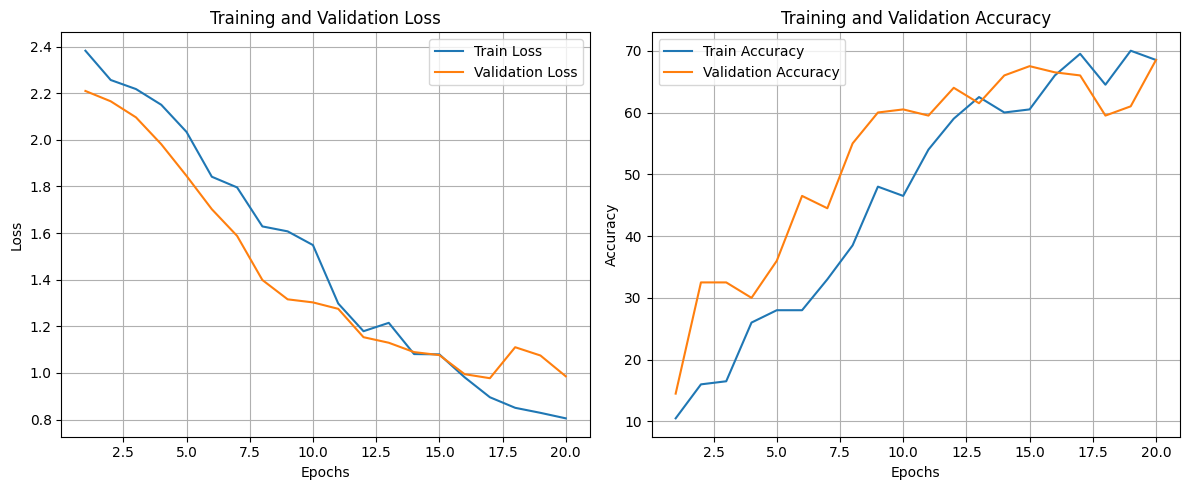

Acurácia da rede na base de teste: 68.50%


In [52]:
model_2 = CNN(
    initialize_weights=True,
    dropout=0.5
)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_2 = train_model(
    model=model_2,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_2,
    optimizer=optimizer_2,
    num_epochs=20
)

plot_training_history(history_2)

test_model(model_2, val_loader)

## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [53]:
# Resolução do Exercício 1
# Estou Definindo a CNN com filtros Parametrizáveis

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, conv1_filters=6, conv2_filters=12):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv1_filters,
            kernel_size=5
        )

        self.conv2 = nn.Conv2d(
            in_channels=conv1_filters,
            out_channels=conv2_filters,
            kernel_size=5
        )

        self.pool = nn.MaxPool2d(2, 2)

        # Dimensão após convoluções e pooling 28x28 → 4x4
        self.fc1 = nn.Linear(conv2_filters * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [54]:
# Função de Treino
def train_model(model, trainloader, criterion, optimizer, epochs=5):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels in trainloader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Época {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


In [55]:
# Função de Avaliação nos quesitos dos testes
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [56]:
# Loop de Expereimentos
# Números de Filtros convolucionais em Self.conv1(6 e 8) e (12 e 16)

import torch.optim as optim

conv1_options = [6, 8]
conv2_options = [12, 16]

results = {}

for c1 in conv1_options:
    for c2 in conv2_options:
        print(f"\nTreinando modelo com conv1={c1} e conv2={c2}")

        model = CNN(conv1_filters=c1, conv2_filters=c2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_model(model, train_loader, criterion, optimizer, epochs=5)
        acc = test_model(model, val_loader)

        results[(c1, c2)] = acc
        print(f"Acurácia no teste: {acc:.2f}%")


Treinando modelo com conv1=6 e conv2=12
Época 1, Loss: 2.3045
Época 2, Loss: 2.2734
Época 3, Loss: 2.2191
Época 4, Loss: 2.1802
Época 5, Loss: 2.0153
Acurácia no teste: 41.00%

Treinando modelo com conv1=6 e conv2=16
Época 1, Loss: 2.3024
Época 2, Loss: 2.2588
Época 3, Loss: 2.2143
Época 4, Loss: 2.1175
Época 5, Loss: 1.9559
Acurácia no teste: 38.50%

Treinando modelo com conv1=8 e conv2=12
Época 1, Loss: 2.2881
Época 2, Loss: 2.2455
Época 3, Loss: 2.1519
Época 4, Loss: 2.0637
Época 5, Loss: 1.8018
Acurácia no teste: 44.00%

Treinando modelo com conv1=8 e conv2=16
Época 1, Loss: 2.2959
Época 2, Loss: 2.2512
Época 3, Loss: 2.1448
Época 4, Loss: 2.0137
Época 5, Loss: 1.7755
Acurácia no teste: 42.00%


In [57]:
# Exibição dos testes realizados
print("\nResultados finais:")
for (c1, c2), acc in results.items():
    print(f"conv1={c1}, conv2={c2} → Acurácia: {acc:.2f}%")



Resultados finais:
conv1=6, conv2=12 → Acurácia: 41.00%
conv1=6, conv2=16 → Acurácia: 38.50%
conv1=8, conv2=12 → Acurácia: 44.00%
conv1=8, conv2=16 → Acurácia: 42.00%


### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [58]:

# Elaborei cum CNN com FC1 parametrizável para análise do exercício 2, eu achei melhor o conjunto abaixo pois explica melhor o conexto, conforme pesquisas realizadas



import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, conv1_filters=8, conv2_filters=16, fc1_neurons=64):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, conv1_filters, kernel_size=5)
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(conv2_filters * 4 * 4, fc1_neurons)
        self.fc2 = nn.Linear(fc1_neurons, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [59]:
# Realizando uma função de treino e teste para o contexto

def train_model(model, trainloader, criterion, optimizer, epochs=5):
    model.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


In [60]:
def test_model(model, testloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [61]:
# Selecionando e executando os 5 treinamentos com valores aleatórios de FC1

import random
import torch.optim as optim

random_fc1_values = random.sample(range(32, 257), 5)  # valores aleatórios
results = {}

print("Valores testados para fc1:", random_fc1_values)

for fc1_neurons in random_fc1_values:
    print(f"\nTreinando modelo com fc1 = {fc1_neurons} neurônios")

    model = CNN(fc1_neurons=fc1_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, epochs=5)
    acc = test_model(model, val_loader)

    results[fc1_neurons] = acc
    print(f"Acurácia no teste: {acc:.2f}%")

Valores testados para fc1: [102, 145, 252, 197, 39]

Treinando modelo com fc1 = 102 neurônios
Acurácia no teste: 46.00%

Treinando modelo com fc1 = 145 neurônios
Acurácia no teste: 48.50%

Treinando modelo com fc1 = 252 neurônios
Acurácia no teste: 60.50%

Treinando modelo com fc1 = 197 neurônios
Acurácia no teste: 59.50%

Treinando modelo com fc1 = 39 neurônios
Acurácia no teste: 42.00%


In [62]:
# Resulado esperado do retorno

print("\nResultados finais:")
for fc1, acc in results.items():
    print(f"fc1 = {fc1} → Acurácia: {acc:.2f}%")



Resultados finais:
fc1 = 102 → Acurácia: 46.00%
fc1 = 145 → Acurácia: 48.50%
fc1 = 252 → Acurácia: 60.50%
fc1 = 197 → Acurácia: 59.50%
fc1 = 39 → Acurácia: 42.00%


# Como você determinaria qual foi o melhor valor?

## Essa escolha deve ser baseada nos critérios abaixo na ordem de prioridade informada

### 1- Maior acurária no conjunto dos testes, o valor de FC1 que obteve a maior acurária é o principal candidato
### 2- a estabilidade do treino evita os valores que oscilam muito entre épocas,  e apresentam perda instável
### 3- o custo computácional, se dois valores riverem acurária semelhante, será necessário preferir o menor número de neurônios e menos parâmetros, com menor riscos de overfitting